In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pmagpy import ipmag, pmag

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, shape, get_angle, PD, eigen_decomposition)                              
from vgptools.utils_compilation import dfs_vgps_recomputed_poles
from vgptools.utils_APWPs import running_mean_APWP_shape, RM_stats, get_vgps_sampling_from_direction
from vgptools.utils_visualization import  RM_stats, plot_VGPs_and_APWP, plot_APWP_RM_ensemble, quantiles,plot_pole_A95, plot_pole, PC
np.random.seed(10)

## 1. Compile the VGPs 

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'

In [3]:
# df_filtered_vgps, df_pole_compilation = dfs_vgps_recomputed_poles(data_path_VGP, by_study = True) # takes as many as poles as are described for one are
df_filtered_vgps = pd.read_csv(current_path +'/data/df_vgps_filtered.csv')

### The following block iterates through ste-sizes and window widths. 

For each combination splits the dataset in train and test subgroiups and runs the MA on the. It calculates the difference between the mean position for each age and stores mean and standart deviation. Repeat this workflow for many (50) train and test sets.

In [ ]:
%%time

min_age = 0
max_age = 55
steps = [1] # [2,5,10] 
window_lengths = range(5,35,1) # [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25] # np.arange(10,35,5)

df_ensemble = pd.DataFrame(columns = ['step_size','window_lenght','n_training','mean_distance','std_distance'])

for step in steps:
    
    for window in window_lengths:

        for i in range(50):

            df_tmp = pd.DataFrame()

            train, test = train_test_split(df_filtered_vgps, test_size=0.5)  # 0.3      

            mean_distances = []
            std_distances = []

            # train_ = get_vgps_sampling_from_direction(train)
            # test_ = get_vgps_sampling_from_direction(test)

            RM_train_ = running_mean_APWP_shape(train, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)
            RM_test_ = running_mean_APWP_shape(test, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)

            distances = []

            for t in RM_train_.age.unique():

                df_train = RM_train_[RM_train_['age']==t]
                df_test = RM_test_[RM_test_['age']==t]

                try:
                    gcd = pmag.angle([df_train['plon'].iat[0], df_train['plat'].iat[0]],
                                     [df_test['plon'].iat[0], df_test['plat'].iat[0]])
                except:
                    continue

                distances.append(gcd)

            mean_distances.append(np.array(distances).mean())
            std_distances.append(np.array(distances).std())
            
            df_ensemble.loc[len(df_ensemble)] = [step, window, i, np.array(mean_distances).mean(), np.array(std_distances).mean()]

df_ensemble.head()

### explore the outcome for one ste_size

In [ ]:
df = df_ensemble[df_ensemble['step_size']==1]
df.head()

,step_size,window_lenght,n_training,mean_distance,std_distance
0,1.0,5.0,0.0,4.749360,3.545239
1,1.0,5.0,1.0,3.884973,2.360916
2,1.0,5.0,2.0,3.870372,3.446418
3,1.0,5.0,3.0,3.569376,2.419408
4,1.0,5.0,4.0,3.901641,2.557182


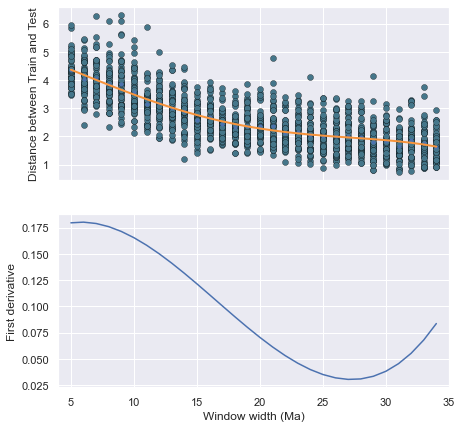

In [344]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

x = sorted(df['window_lenght'].unique())
y = df.groupby('window_lenght')['mean_distance'].mean().to_numpy() # splines cannot have repeated X's

s = UnivariateSpline(x, y, s = 1000, k = 4)

xs = sorted(df['window_lenght'].unique())
ys = s(xs)

xsd = sorted(df['window_lenght'].unique())
ysd = np.absolute(np.array([s.derivatives(x)[1] for x in xsd]))

fig, axs = plt.subplots(2, sharex =True, figsize=(7,7))

sns.set_theme(style="darkgrid")

# sns.scatterplot(x="window_lenght", y="mean_distance",  
#              data=df, 
#              ax = axs[0], legend = True, palette='GnBu_d')
axs[0].scatter(x=df["window_lenght"].to_list(), y=df["mean_distance"].to_list(), 
               color = '#45768A', edgecolor = 'black',linewidth=0.3)

axs[0].plot(x, y, '.')
axs[0].plot(xs, ys,color = '#F7943C',linewidth=2)
axs[1].plot(xsd, ysd)

axs[0].set_ylabel('Distance between Train and Test')

axs[1].set_xlim(4,35)
axs[1].set_ylabel('First derivative')
axs[1].set_xlabel('Window width (Ma)')
plt.savefig(current_path + '/figures/5/cross_val.svg', dpi =600, bbox_inches='tight')
plt.show()

## Derivatives method

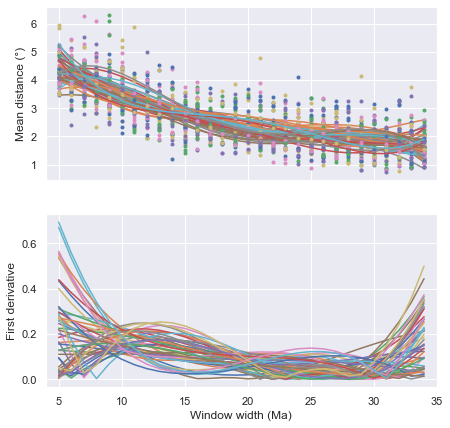

<AxesSubplot:ylabel='Count'>

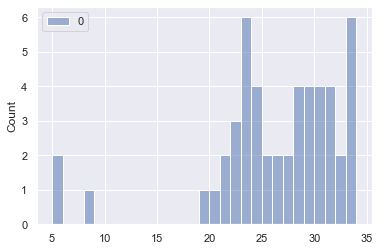

In [345]:
fig, axs = plt.subplots(2, sharex =True, figsize=(7,7))
sns.set_theme(style="darkgrid")

min_d = []

for n_train, df_train in df.groupby('n_training'):
    
    # if n_train == 12:
    x = np.sort(df_train['window_lenght'].unique())
    y = df_train['mean_distance'].to_numpy() # splines cannot have repeated X's

    s = UnivariateSpline(x, y, s = 10000, k = 4)

    xs = sorted(df['window_lenght'].unique())
    ys = s(xs)

    xsd = sorted(df['window_lenght'].unique())
    ysd = np.absolute(np.array([s.derivatives(x)[1] for x in xsd]))

    min_d.append(x[ysd.argmin()])

    axs[0].plot(x, y, '.')
    axs[0].plot(xs, ys)
    axs[1].plot(xsd, ysd)

df_derivatives = pd.DataFrame(min_d)


axs[0].set_ylabel('Mean distance (°)')
axs[1].set_xlim(4,35)
axs[1].set_ylabel('First derivative')
axs[1].set_xlabel('Window width (Ma)')

plt.show()
sns.histplot(df_derivatives, binwidth = 1)

## Kneed methos

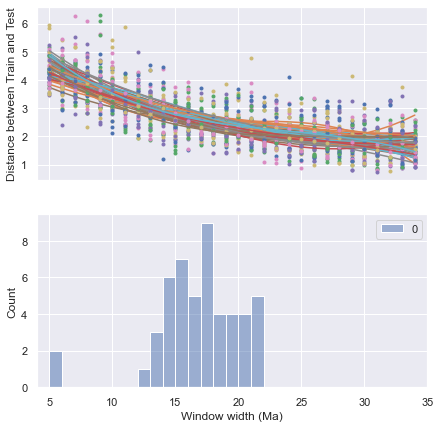

In [346]:
fig, axs = plt.subplots(2, sharex =True, figsize=(7,7))
sns.set_theme(style="darkgrid")

polynomial_degree = 6

knees = []

for n_train, df_train in df.groupby('n_training'):
       
    # try to bound the search in the range (15,30) 
    
    interval = range(5,35)
    
    df_ = df_train[df_train['window_lenght'].isin(interval)]
    
    x = np.sort(df_['window_lenght'].unique())
    y = df_['mean_distance'].to_numpy() # splines cannot have repeated X's
    
    s = UnivariateSpline(x, y,  k = 3)
    
    kneedle = KneeLocator(x, s(x), S=1.0, interp_method="interp1d", polynomial_degree = polynomial_degree, 
                          curve="convex", direction="decreasing")

    knees.append(kneedle.knee)

    axs[0].plot(x, y, '.')
    axs[0].plot(x, s(x))
    
    # axs[1].plot(xsd, ysd)
    
axs[0].set_ylabel('Distance between Train and Test')
axs[1].set_xlim(4,35)
axs[1] = sns.histplot(df_knees, binwidth = 1)
# axs[1].set_ylabel('First derivative')
axs[1].set_xlabel('Window width (Ma)')

plt.show()
df_knees = pd.DataFrame(knees)
# sns.histplot(df_knees, binwidth = 1)

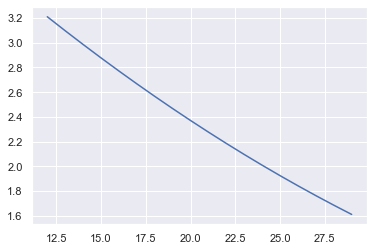

In [296]:
from scipy import interpolate

s = UnivariateSpline(x, y, s = 1000, k = 2)
yy = s(x)
uspline = interpolate.interp1d(x, s(x))
yy = uspline(x)
plt.plot(x, yy)

In [225]:
df_test = df[df['n_training']==1]

x = np.sort(df_test['window_lenght'].unique())
y = df_test['mean_distance'].to_numpy()

kneedle = KneeLocator(x, y, S=1.0, 
                      interp_method="polynomial", polynomial_degree = 4, 
                      curve="convex", direction="decreasing")

kneedle.knee

15.0

In [ ]:
from kneed import DataGenerator, KneeLocator


y = s(np.arange(10,30,1))
x = np.arange(10,30,1)

kneedle = KneeLocator(x, y, S=1.0, 
                      interp_method="polynomial", polynomial_degree = 4, 
                      curve="convex", direction="decreasing")

print(round(kneedle.knee, 3))

20


In [ ]:
y

array([4.015839576173946, 4.044460482826048, 4.018717391607216,
       3.948027310403663, 3.84116199390489 , 3.70624794360368 ,
       3.550766407796101, 3.381553381581512, 3.204799606862554,
       3.026050572345152, 2.850206513538525, 2.681522412755168,
       2.523607999110868, 2.379427748524698, 2.251300883719013,
       2.140901374219457, 2.049257936354958, 1.976754033257731,
       1.923127874863278, 1.887472417910384, 1.868235365941121,
       1.86321916930085 , 1.869581025138212, 1.883832877405138,
       1.901841416856844])

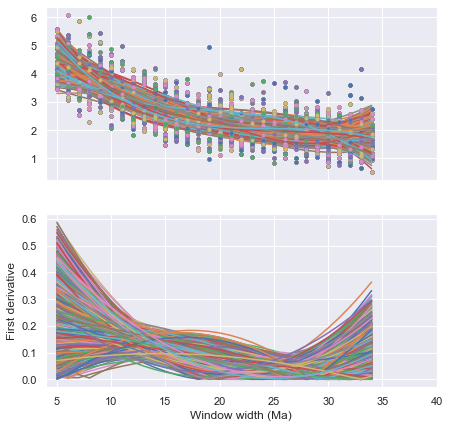

<AxesSubplot:ylabel='Count'>

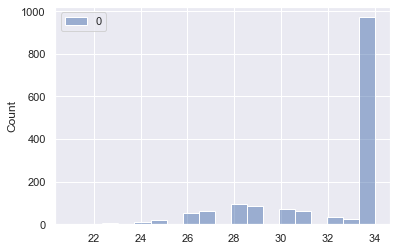

In [222]:
fig, axs = plt.subplots(2, sharex =True, figsize=(7,7))
sns.set_theme(style="darkgrid")

min_d = []
min_cost = []

for i in range(len(df)):

    x = np.sort(df['window_lenght'].unique())
    y = df.groupby('window_lenght')['mean_distance'].sample(n=1).to_numpy() # splines cannot have repeated X's

    s = UnivariateSpline(x, y, s = 1000, k = 3)

    xs = sorted(df['window_lenght'].unique())
    ys = s(xs)

    xsd = sorted(df['window_lenght'].unique())
    ysd = np.absolute(np.array([s.derivatives(x)[1] for x in xsd]))

    min_d.append(x[ysd.argmin()])
    min_cost.append(x[ys.argmin()])

    axs[0].plot(x, y, '.')
    axs[0].plot(xs, ys)
    axs[1].plot(xsd, ysd)

df_derivatives = pd.DataFrame(min_d)
df_mins = pd.DataFrame(min_cost)

axs[1].set_xlim(4,40)
axs[1].set_ylabel('First derivative')
axs[1].set_xlabel('Window width (Ma)')

plt.show()

sns.histplot(df_derivatives)
sns.histplot(df_mins)

### Second excersise:

We split in train and test. We calculate a MA for the train. We measure the mean distance of the vgps of the test against the corresponding MA from train. 

In [50]:
%%time

min_age = 0
max_age = 55
steps = [1,2,5,10] # [2,5,10] 
window_lengths =  range(5,35,1)# [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25] # np.arange(10,35,5)

df_ensemble = pd.DataFrame(columns = ['step_size','window_lenght','n_training','mean_distance','std_distance'])

for step in steps:
    
    for window in window_lengths:

        for i in range(50):

            df_tmp = pd.DataFrame()

            train, test = train_test_split(df_filtered_vgps, test_size=0.3)        

            mean_distances = []
            std_distances = []

            # calculate a MA for the train dataset
            RM_train_ = running_mean_APWP_shape(train, 'vgp_lon_SH', 'vgp_lat_SH', 'mean_age', window, step, max_age, min_age)

            distances = []

            for t in RM_train_.age.unique():

                df_train = RM_train_[RM_train_['age']==t]
                df_test = test[test['mean_age'].between(t-window/2, t+window/2)] # select all VGPs on the test that falls in the window for which we calculated the MA
                
                for _,row in df_test.iterrows():
                    
                    try:
                        # we measure all the VGPs of the test set within a window against the position in the MA in the train
                        gcd = pmag.angle([df_train['plon'].iat[0], df_train['plat'].iat[0]],
                                         [row.vgp_lon_SH, row.vgp_lat_SH])
                    except:
                        continue
                    distances.append(gcd)
                

            mean_distances.append(np.array(distances).mean())
            std_distances.append(np.array(distances).std())
            
            df_ensemble.loc[len(df_ensemble)] = [step, window, i, np.array(mean_distances).mean(), np.array(std_distances).mean()]

df_ensemble.head()

CPU times: user 43min 57s, sys: 9.14 s, total: 44min 6s
Wall time: 44min 3s


,step_size,window_lenght,n_training,mean_distance,std_distance
0,1.0,5.0,0.0,16.862008,11.828879
1,1.0,5.0,1.0,18.764412,13.134440
2,1.0,5.0,2.0,17.582752,11.502693
3,1.0,5.0,3.0,16.236511,11.185521
4,1.0,5.0,4.0,17.550358,11.922201


<AxesSubplot:xlabel='window_lenght', ylabel='std_distance'>

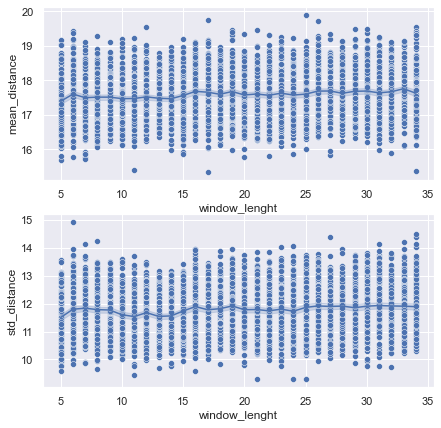

In [51]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2,1, figsize=(7,7))

sns.scatterplot(x="window_lenght", y="mean_distance",  
             data=df_ensemble, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.lineplot(x="window_lenght", y="mean_distance",  
             data=df_ensemble, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.scatterplot(x="window_lenght", y="std_distance",
             data=df_ensemble, 
             ax = ax[1], legend = True, palette='GnBu_d')

sns.lineplot(x="window_lenght", y="std_distance",
             data=df_ensemble, 
             ax = ax[1], legend = True, palette='GnBu_d')

In [ ]:
df = df_ensemble[df_ensemble['step_size']==2]

<AxesSubplot:xlabel='window_lenght', ylabel='std_distance'>

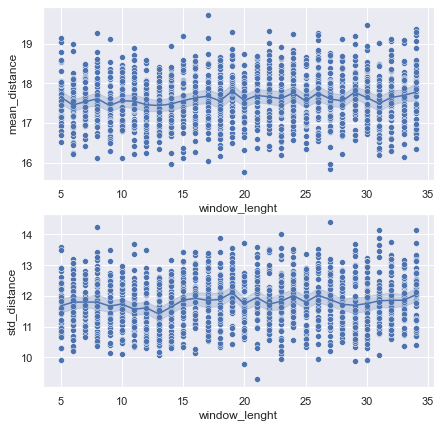

In [ ]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(2,1, figsize=(7,7))

sns.scatterplot(x="window_lenght", y="mean_distance",  
             data=df, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.lineplot(x="window_lenght", y="mean_distance",  
             data=df, 
             ax = ax[0], legend = True, palette='GnBu_d')

sns.scatterplot(x="window_lenght", y="std_distance",
             data=df, 
             ax = ax[1], legend = True, palette='GnBu_d')

sns.lineplot(x="window_lenght", y="std_distance",
             data=df, 
             ax = ax[1], legend = True, palette='GnBu_d')

In [ ]:
df[df['mean_distance'].between(1, 14.5)]

,step_size,window_lenght,n_training,mean_distance,std_distance
2250,2.0,5.0,0.0,4.657225,2.905795
2251,2.0,5.0,1.0,5.732736,6.085922
2252,2.0,5.0,2.0,5.511360,6.098883
2253,2.0,5.0,3.0,3.561052,2.359034
2254,2.0,5.0,4.0,3.881417,2.544652
...,...,...,...,...,...
4493,2.0,49.0,43.0,2.197084,1.127821
4495,2.0,49.0,45.0,1.846569,0.714920
4496,2.0,49.0,46.0,2.282552,0.848668
4497,2.0,49.0,47.0,1.313469,0.622891
